In [1]:
import os
import torch
import numpy as np
import pandas as pd
from datasets import load_dataset
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    get_linear_schedule_with_warmup,
    set_seed
)
from peft import (
    get_peft_model,
    LoraConfig,
    TaskType,
    prepare_model_for_kbit_training
)
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    average_precision_score
)
import matplotlib.pyplot as plt

# Set seed for reproducibility
set_seed(42)



/miniforge/envs/pt/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Model configuration
# Choose your desired model here
MODEL_NAME = "facebook/opt-350m"  # A smaller model for faster testing
# Other options: 
# - "meta-llama/Llama-2-7b-hf" (requires access)
# - "google/flan-t5-small"
# - "mistralai/Mistral-7B-v0.1" (requires access)

# Training parameters
MAX_LENGTH = 128
BATCH_SIZE = 8
EPOCHS = 3
LEARNING_RATE = 2e-5

# Dataset parameters
TRAIN_SAMPLES = 1000  # Number of training examples to use
TEST_SAMPLES = 200    # Number of test examples to use



Using device: cuda


In [7]:
from sklearn.model_selection import train_test_split
import pandas as pd
from datasets import Dataset, load_dataset

def load_binary_classification_dataset():
    """Load a binary classification dataset from Hugging Face"""
    # You can replace this with any binary classification dataset
    dataset = load_dataset("imdb")
    df = pd.DataFrame(dataset["train"])

    # Stratified split to ensure both classes exist
    train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)

    # Convert back to HF Datasets and select samples
    train_dataset = Dataset.from_pandas(train_df.reset_index(drop=True)).select(range(1000))
    test_dataset = Dataset.from_pandas(test_df.reset_index(drop=True)).select(range(200))
    
    print(f"Loaded {len(train_dataset)} training samples")
    print(f"Loaded {len(test_dataset)} test samples")
    print(f"Labels: {dataset['train'].features['label'].names}")
    print(f"\nSample data:")
    print(train_dataset[0])
    
    return train_dataset, test_dataset

def preprocess_data(dataset, tokenizer):
    """Tokenize and prepare the dataset"""
    def tokenize_function(examples):
        return tokenizer(
            examples["text"],
            padding="max_length",
            truncation=True,
            max_length=MAX_LENGTH,
            return_tensors="pt"
        )
    
    tokenized_dataset = dataset.map(tokenize_function, batched=True)
    tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
    tokenized_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
    
    return tokenized_dataset

def create_dataloader(dataset, batch_size):
    """Create a DataLoader for the dataset"""
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True
    )



In [8]:
def train_model(model, train_dataloader, optimizer, scheduler, epochs):
    """Training function for fine-tuning"""
    model.train()
    
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        total_loss = 0
        
        progress_bar = tqdm(train_dataloader)
        for batch in progress_bar:
            batch = {k: v.to(device) for k, v in batch.items()}
            
            optimizer.zero_grad()
            
            outputs = model(**batch)
            loss = outputs.loss
            
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            total_loss += loss.item()
            progress_bar.set_description(f"Loss: {loss.item():.4f}")
            
        avg_loss = total_loss / len(train_dataloader)
        print(f"Average loss: {avg_loss:.4f}")

def evaluate_model(model, test_dataloader):
    """Evaluate model and compute metrics"""
    model.eval()
    
    all_preds = []
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc="Evaluating"):
            batch = {k: v.to(device) for k, v in batch.items()}
            
            outputs = model(**batch)
            logits = outputs.logits
            
            # Get probabilities and predictions
            probs = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            labels = batch["labels"].cpu().numpy()
            
            all_probs.extend(probs)
            all_preds.extend(preds)
            all_labels.extend(labels)
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_probs)
    pr_auc = average_precision_score(all_labels, all_probs)
    
    metrics = {
        "accuracy": accuracy,
        "AUC": auc,
        "PR-AUC": pr_auc
    }
    
    print(f"Evaluation metrics:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  AUC-ROC:  {auc:.4f}")
    print(f"  PR-AUC:   {pr_auc:.4f}")
    
    return metrics



In [9]:
def plot_results(results):
    """Plot comparison of different fine-tuning methods"""
    metrics = list(next(iter(results.values())).keys())
    models = list(results.keys())

    fig, ax = plt.subplots(1, len(metrics), figsize=(15, 5))

    for i, metric in enumerate(metrics):
        values = [results[model][metric] for model in models]
        ax[i].bar(models, values)
        ax[i].set_title(metric)
        ax[i].set_ylim(0, 1)
        plt.setp(ax[i].get_xticklabels(), rotation=45, ha='right')

    plt.tight_layout()
    plt.savefig("fine_tuning_comparison.png")
    print("Results plot saved as 'fine_tuning_comparison.png'")

def main():
    results = {}
    
    # 1. Load and prepare data
    print("\n=== Loading dataset ===")
    train_dataset, test_dataset = load_binary_classification_dataset()
    
    # 2. Load tokenizer
    print("\n=== Loading tokenizer ===")
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    
    # Check if tokenizer has pad_token, if not set it to eos_token
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
        print(f"Set pad_token to eos_token: {tokenizer.pad_token}")
    
    # 3. Preprocess data
    print("\n=== Preprocessing data ===")
    train_tokenized = preprocess_data(train_dataset, tokenizer)
    test_tokenized = preprocess_data(test_dataset, tokenizer)
    
    train_dataloader = create_dataloader(train_tokenized, BATCH_SIZE)
    test_dataloader = create_dataloader(test_tokenized, BATCH_SIZE)
    
    # Calculate total steps for schedulers
    total_steps = len(train_dataloader) * EPOCHS
    
    # 4. Base model evaluation
    print("\n=== Loading base model ===")
    base_model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=2,
    )
    base_model.config.pad_token_id = tokenizer.pad_token_id
    base_model = base_model.to(device)
    
    print("\n=== Evaluating base model performance (no fine-tuning) ===")
    results["Base Model"] = evaluate_model(base_model, test_dataloader)
    
    # 5. Last layer fine-tuning
    print("\n=== Loading model for last layer fine-tuning ===")
    last_layer_model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=2,
    )
    last_layer_model.config.pad_token_id = tokenizer.pad_token_id
    
    # Freeze all layers except classification head
    # Freeze everything
    for param in last_layer_model.parameters():
        param.requires_grad = False

    # Unfreeze classification head
    for name, param in last_layer_model.named_parameters():
        if any(head in name.lower() for head in ["score", "lm_head", "classifier"]):
            param.requires_grad = True

    
    # Move model to device
    last_layer_model = last_layer_model.to(device)
    
    # Check which parameters are being trained
    trainable_params = sum(p.numel() for p in last_layer_model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in last_layer_model.parameters())
    print(f"Trainable parameters: {trainable_params} ({trainable_params/total_params:.2%} of total)")
    
    # Training setup
    optimizer = torch.optim.AdamW(
        [p for p in last_layer_model.parameters() if p.requires_grad], 
        lr=LEARNING_RATE
    )
    
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(0.1 * total_steps),
        num_training_steps=total_steps
    )
    
    # Train and evaluate
    print("\n=== Training last layer ===")
    train_model(last_layer_model, train_dataloader, optimizer, scheduler, EPOCHS)
    
    print("\n=== Evaluating last layer fine-tuned model ===")
    results["Last Layer Fine-tuning"] = evaluate_model(last_layer_model, test_dataloader)
    
    # 6. LoRA fine-tuning
    print("\n=== Loading model for LoRA fine-tuning ===")
    lora_model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=2,
    )
    lora_model.config.pad_token_id = tokenizer.pad_token_id
    
    # Determine target modules based on model architecture
    if "llama" in MODEL_NAME.lower() or "mistral" in MODEL_NAME.lower():
        target_modules = ["q_proj", "v_proj"]
    elif "opt" in MODEL_NAME.lower() or "gpt" in MODEL_NAME.lower():
        target_modules = ["q_proj", "v_proj"]
    elif "t5" in MODEL_NAME.lower():
        target_modules = ["q", "v"]
    else:
        # Default for most transformer models
        target_modules = ["query", "value"]
    
    # Configure LoRA
    lora_config = LoraConfig(
        task_type=TaskType.SEQ_CLS,
        r=8,  # Rank
        lora_alpha=32,
        lora_dropout=0.1,
        target_modules=target_modules
    )
    
    # Apply LoRA
    lora_model = get_peft_model(lora_model, lora_config)
    lora_model = lora_model.to(device)
    
    # Print trainable parameters
    lora_model.print_trainable_parameters()
    
    # Training setup
    optimizer = torch.optim.AdamW(
        [p for p in lora_model.parameters() if p.requires_grad], 
        lr=LEARNING_RATE
    )
    
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(0.1 * total_steps),
        num_training_steps=total_steps
    )
    
    # Train and evaluate
    print("\n=== Training with LoRA ===")
    train_model(lora_model, train_dataloader, optimizer, scheduler, EPOCHS)
    
    print("\n=== Evaluating LoRA fine-tuned model ===")
    results["LoRA Fine-tuning"] = evaluate_model(lora_model, test_dataloader)
    
    # 7. QLoRA fine-tuning
    print("\n=== Loading model for QLoRA fine-tuning ===")
    try:
        # Load model in 4-bit to enable QLoRA
        qlora_model = AutoModelForSequenceClassification.from_pretrained(
            MODEL_NAME,
            num_labels=2,
            load_in_4bit=True,
            device_map="auto",
        )
        qlora_model.config.pad_token_id = tokenizer.pad_token_id
        
        # Prepare model for k-bit training
        qlora_model = prepare_model_for_kbit_training(qlora_model)
        
        # Configure LoRA for QLoRA
        qlora_config = LoraConfig(
            task_type=TaskType.SEQ_CLS,
            r=8,
            lora_alpha=32,
            lora_dropout=0.1,
            target_modules=target_modules,
            bias="none",
            modules_to_save=["classifier"]
        )
        
        # Apply LoRA
        qlora_model = get_peft_model(qlora_model, qlora_config)
        
        # Print trainable parameters
        qlora_model.print_trainable_parameters()
        
        # Training setup
        optimizer = torch.optim.AdamW(
            [p for p in qlora_model.parameters() if p.requires_grad], 
            lr=LEARNING_RATE
        )
        
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=int(0.1 * total_steps),
            num_training_steps=total_steps
        )
        
        # Train and evaluate
        print("\n=== Training with QLoRA ===")
        train_model(qlora_model, train_dataloader, optimizer, scheduler, EPOCHS)
        
        print("\n=== Evaluating QLoRA fine-tuned model ===")
        results["QLoRA Fine-tuning"] = evaluate_model(qlora_model, test_dataloader)
    except Exception as e:
        print(f"Error with QLoRA: {e}")
        print("This may happen if bitsandbytes is not properly installed or you're on an unsupported platform.")
        print("Skipping QLoRA evaluation.")
    
    # 8. Results comparison
    print("\n=== Results Comparison ===")
    df_results = pd.DataFrame.from_dict(results, orient='index')
    print(df_results)
    
    # Plot results
    try:
        plot_results(results)
    except Exception as e:
        print(f"Error plotting results: {e}")
    
    # Save models if needed
    output_dir = "fine_tuned_models"
    os.makedirs(output_dir, exist_ok=True)
    
    # Save LoRA model - this only saves the adapter weights, not the full model
    lora_model.save_pretrained(f"{output_dir}/lora_model")
    print(f"LoRA model saved to {output_dir}/lora_model")
    
    # Save QLoRA model if available
    if 'QLoRA Fine-tuning' in results:
        qlora_model.save_pretrained(f"{output_dir}/qlora_model")
        print(f"QLoRA model saved to {output_dir}/qlora_model")
    
    print("\n=== Fine-tuning complete! ===")




=== Loading dataset ===
Loaded 1000 training samples
Loaded 200 test samples
Labels: ['neg', 'pos']

Sample data:
{'text': 'I have always been a huge James Bond fanatic! I have seen almost all of the films except for Die Another Day, and The World Is Not Enough. The graphic\'s for Everything Or Nothing are breathtaking! The voice talents......... WOW! I LOVE PIERCE BROSNAN! He is finally Bond in a video game! HE IS BOND! I enjoyed the past Bond games: Goldeneye, The World Is Not Enough, Agent Under Fire, and Nightfire. This one is definitely the best! Finally, Mr. Brosnan, (may I call him Mr. Brosnan as a sign of respect? Yes I can!) He was phenomenally exciting to hear in a video game....... AT LONG LAST! DUH! I\'ve seen him perform with Robin Williams, and let me tell you, they make a great team. Pierce Brosnan is funny, wickedly handsome ( I mean to say wickedly in a good way,) and just one of those actor\'s who you would want to walk up to and wrap your arms around and hug, saying

Map: 100%|██████████| 200/200 [00:00<00:00, 4176.74 examples/s]



=== Loading base model ===


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-350m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Evaluating base model performance (no fine-tuning) ===


Evaluating: 100%|██████████| 25/25 [00:01<00:00, 21.39it/s]


Evaluation metrics:
  Accuracy: 0.4600
  AUC-ROC:  0.4228
  PR-AUC:   0.4653

=== Loading model for last layer fine-tuning ===


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-350m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable parameters: 1024 (0.00% of total)

=== Training last layer ===

Epoch 1/3


Loss: 1.2862: 100%|██████████| 125/125 [00:06<00:00, 20.75it/s]


Average loss: 1.2370

Epoch 2/3


Loss: 1.1497: 100%|██████████| 125/125 [00:05<00:00, 20.97it/s]


Average loss: 1.0348

Epoch 3/3


Loss: 1.1822: 100%|██████████| 125/125 [00:05<00:00, 21.09it/s]


Average loss: 0.9707

=== Evaluating last layer fine-tuned model ===


Evaluating: 100%|██████████| 25/25 [00:01<00:00, 21.57it/s]


Evaluation metrics:
  Accuracy: 0.5550
  AUC-ROC:  0.5582
  PR-AUC:   0.5557

=== Loading model for LoRA fine-tuning ===


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-350m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 787,456 || all params: 331,984,896 || trainable%: 0.2372

=== Training with LoRA ===

Epoch 1/3


Loss: 1.4000: 100%|██████████| 125/125 [00:11<00:00, 10.54it/s]


Average loss: 1.6177

Epoch 2/3


Loss: 0.3682: 100%|██████████| 125/125 [00:11<00:00, 10.58it/s]


Average loss: 1.1572

Epoch 3/3


Loss: 1.3966: 100%|██████████| 125/125 [00:11<00:00, 10.56it/s]


Average loss: 0.9768

=== Evaluating LoRA fine-tuned model ===


Evaluating: 100%|██████████| 25/25 [00:01<00:00, 20.63it/s]


Evaluation metrics:
  Accuracy: 0.4600
  AUC-ROC:  0.4714
  PR-AUC:   0.5282

=== Loading model for QLoRA fine-tuning ===
Error with QLoRA: No package metadata was found for bitsandbytes
This may happen if bitsandbytes is not properly installed or you're on an unsupported platform.
Skipping QLoRA evaluation.

=== Results Comparison ===
                        accuracy     AUC    PR-AUC
Base Model                 0.460  0.4228  0.465289
Last Layer Fine-tuning     0.555  0.5582  0.555738
LoRA Fine-tuning           0.460  0.4714  0.528221
Results plot saved as 'fine_tuning_comparison.png'
LoRA model saved to fine_tuned_models/lora_model

=== Fine-tuning complete! ===


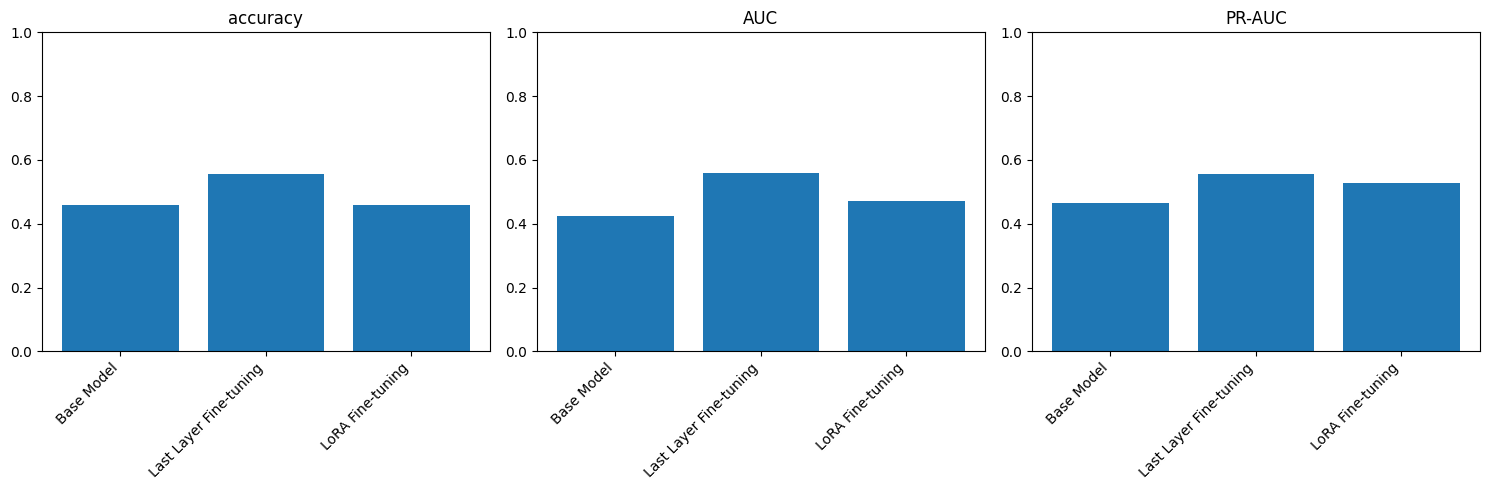

In [10]:
if __name__ == "__main__":
    main()